# Training
C'est parti maintenant pour l'entrainement sur les données pre-traitees et avec l'algo dans l'espace des vecteurs propres, derniere etape avant le calcul de la constante de Lipschitz.

In [1]:
# importation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# local
from MyResNet.pretreat import LoadDataSet, CreateDataSet
from MyResNet.myfunc import Physics
from MyResNet.myfunc import MyMatmul
from MyResNet.model import MyModel

### Paramètres physiques 

In [2]:
a   = 1
p   = 1
nx  = 2000
m   = 20
sim = Physics(nx,m,a,p)

### Charge les donnees

In [3]:
folder  = './MyResNet/Datasets'
nsample = 50
train_set, val_set = CreateDataSet(sim,folder,noise=0.0,nsample=nsample)

torch.Size([600, 1, 20])


### On definit le modèle 

In [4]:
mymodel = MyModel(sim,2000)

### On definit la loss

In [5]:
loss_fn = nn.MSELoss(reduction='mean')

### Fonction Training

In [6]:
def train(model,train_set,val_set,nb_epochs):
    """
    Trains iRestNet.
    """      
    # to store results
    loss_train   =  np.zeros(nb_epochs)
    loss_val     =  np.zeros(nb_epochs)
    loss_min_val =  float('Inf')
    # defines the optimizer
    lr_i        = 0.01
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=lr_i)

    #==========================================================================================================
    # trains for several epochs
    for epoch in range(0,nb_epochs): 
        # sets training mode
        model.train()
        # modifies learning rate
        if epoch>0:
            lr_i      = lr_i*0.9 
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=lr_i)
        # TRAINING
        # goes through all minibatches
        for i,minibatch in enumerate(train_set):
            [y, x] = minibatch    # get the minibatch
            x_init    = Variable(y,requires_grad=False)
            x_true    = Variable(x,requires_grad=False)
            x_pred    = model(x_init,x_init) 
                    
            # Computes and prints loss
            loss                = loss_fn(x_pred, x_true)
            loss_train[epoch] += torch.Tensor.item(loss)
                    
            # sets the gradients to zero, performs a backward pass, and updates the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # normalisation
        loss_train[epoch] = loss_train[epoch]/i
        #
        #
        # VALIDATION AND STATS
        if epoch%1==0:
            with torch.no_grad():
            # saves signal and model state  
            # utils.save_image(x_pred.data,os.path.join(
            #            folder,'training',str(epoch)+'_restored_images.png'),normalize=True)
            # torch.save(self.last_layer.state_dict(),os.path.join(folder,'trained_post-processing.pt'))
            # torch.save(self.model.state_dict(),os.path.join(folder,'trained_model.pt'))

            # tests on validation set
                model.eval()      # evaluation mode
                for i,minibatch in enumerate(val_set):
                    [y, x] = minibatch            # gets the minibatch
                    x_true    = Variable(x,requires_grad=False)
                    x_init    = Variable(y,requires_grad=False)
                    x_pred = model(x_init,x_init).detach()
                    
                    # computes loss on validation set
                    loss_val[epoch] += torch.Tensor.item(loss_fn(x_pred, x_true))
                # normalisation
                loss_val[epoch] = loss_val[epoch]/i
            # print stat
            print("epoch : ", epoch," ----- ","validation : ",loss_val[epoch])


               
               
            
    #==========================================================================================================
    # training is finished
    print('-----------------------------------------------------------------')
    print('Training is done.')
    print('-----------------------------------------------------------------')

    return loss_train, loss_val

In [7]:
#loss_t, loss_v = train(mymodel,train_set,val_set,10)

In [9]:
# plt.plot(loss_t,label = 'train')
# plt.plot(loss_v,label = 'val')
# plt.legend()

### Show result of the trained model

In [10]:
lxtrue = []
lxpred = []
mymodel.eval()      # evaluation mode
# Run the testing batches
with torch.no_grad():
    for i,minibatch in enumerate(val_set):
        [y, x] = minibatch            # gets the minibatch
        x_true    = Variable(x,requires_grad=False)
        x_init    = Variable(y,requires_grad=False)
        x_pred = mymodel(x_init,x_init).detach()
        lxtrue.append(x_true[0,0].numpy())
        lxpred.append(x_pred[0,0].numpy())

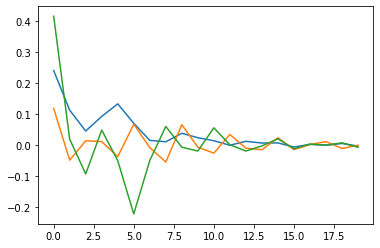

In [11]:
plt.plot(lxpred[0])
plt.plot(lxpred[1])
plt.plot(lxpred[12])

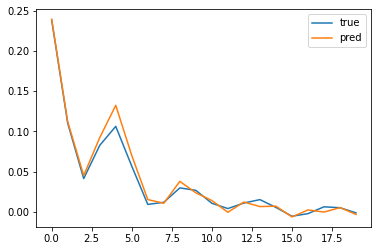

In [12]:
plt.plot(lxtrue[0],label='true')
plt.plot(lxpred[0],label='pred')
plt.legend()

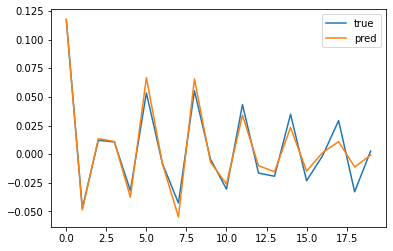

In [13]:
plt.plot(lxtrue[1],label='true')
plt.plot(lxpred[1],label='pred')
plt.legend()

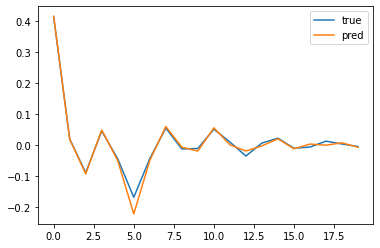

In [14]:
plt.plot(lxtrue[12],label='true')
plt.plot(lxpred[12],label='pred')
plt.legend()

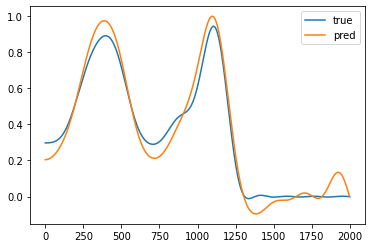

In [15]:
plt.plot(sim.BasisChangeInv(lxtrue[12]),label='true')
plt.plot(sim.BasisChangeInv(lxpred[12]),label='pred')
plt.legend()